# **Data - 나영**

### **Load Modules**

In [106]:
# Utils
import numpy as np
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import os
import torchvision.models as models
from utility.early_stopping import EarlyStopping
# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler


import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
from tensorboardX import SummaryWriter

# sklearn
from sklearn.metrics import confusion_matrix, classification_report


**Seed Setting**

In [2]:
random.seed(0)

**Device Setting**

In [3]:
# 디바이스 설정
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

**Set Hyperparameters**

In [4]:
batch_size = 128
num_epochs = 1
learning_rate = 0.001
momentum = 0.9

# Data Preprocessing

In [5]:
train_val_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(),
    transforms.RandomCrop(32, padding=4), 
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])
])

### **Load Data**

**Splitting th training data**

In [6]:
train_val_data = datasets.CIFAR100(root='./data', train=True, download=True, transform=train_val_transform)
test_data = datasets.CIFAR100(root='./data', train=False, download=True, transform=test_transform)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
# train_data = datasets.CIFAR100(root='./data', train=True, download=True, transform=train_transform)
# test_data = datasets.CIFAR100(root='./data', train=False, download=True, transform=test_transform)

In [8]:
# train 데이터를 train/val로 나누기
num_train = len(train_val_data)
indices = list(range(num_train))
split = int(np.floor(0.2 * num_train))  # validation 데이터를 20%로 설정

np.random.shuffle(indices)
train_idx, val_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

**Define DataLoader**

In [9]:
train_loader = DataLoader(train_val_data, batch_size=batch_size, sampler=train_sampler, num_workers=2)
val_loader = DataLoader(train_val_data, batch_size=batch_size, sampler=val_sampler, num_workers=2)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)

# **Model - 하연**

models 폴더에 만들고 import 하는 식으로 해주세요

**Training Loop**

In [10]:
# # models 폴더의 경로 추가
# sys.path.append('./models')

print("use:", device)

# 모델 import 하기
from models.resnetRS import ResNetRS18
from models import resnet

# 모델 초기화
net = resnet.resnet18()

# 모델을 GPU로 이동
net.to(device)

# 모델 구조 출력
print(summary(net, (3, 224, 224)))

use: cuda:0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,728
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,864
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
            Conv2d-7         [-1, 64, 224, 224]          36,864
       BatchNorm2d-8         [-1, 64, 224, 224]             128
        BasicBlock-9         [-1, 64, 224, 224]               0
           Conv2d-10         [-1, 64, 224, 224]          36,864
      BatchNorm2d-11         [-1, 64, 224, 224]             128
             ReLU-12         [-1, 64, 224, 224]               0
           Conv2d-13         [-1, 64, 224, 224]          36,864
      BatchNorm2d-14       

### **Loss and Optimizer**

In [11]:
# 손실함수 초기화
criterion = nn.CrossEntropyLoss()

# 옵티마이저 초기화
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

# 옵티마이저의 state_dict 출력
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.001, 'momentum': 0.9, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'maximize': False, 'foreach': None, 'differentiable': False, 'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61]}]


# **Train - 하연**

### **Model Train**

In [12]:
writer = SummaryWriter("./runs/resnet_18/tensorboard")

In [13]:
# save_path = "./runs/resnet_18/checkpoints"
# early_stopping = EarlyStopping(save_path)
early_stopping = EarlyStopping(patience=5, verbose=True)

In [14]:
# 모델 학습 함수
def train_model(model, trainloader, criterion, optimizer, num_epochs=25):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch_idx, (inputs, labels) in enumerate(trainloader):
            labels = labels.type(torch.LongTensor).to(device)  # CPU에서 long type tensor로 변환
            inputs = inputs.to(device)

            optimizer.zero_grad()

            # 모델 예측
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # 역전파 및 최적화
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

            # 30번째 배치마다 상태 출력
            if (batch_idx + 1) % 30 == 0:
                print(f"Batch [{batch_idx+1}/{len(trainloader)}], Loss: {loss.item():.4f}")

        # Epoch당 평균 손실 계산 및 출력
        epoch_loss = running_loss / len(trainloader.dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

        # Early Stopping 체크
        early_stopping(epoch_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

**Model Test**

In [15]:
# 모델 평가 및 테스트 함수 (superclass 예측 포함)
def test_model(model, testloader, criterion, epoch):
    model.eval()
    test_loss = 0.0
    correct = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # 모델 예측
            outputs = model(inputs)
            test_loss += criterion(outputs, labels).item() * inputs.size(0)
            
            # 예측 결과 저장 및 정확도 계산
            pred = outputs.argmax(dim=1)
            correct += (pred == labels).sum().item()

            # TensorBoard에 테스트 손실 및 정확도 기록
            writer.add_scalar("Test Loss", test_loss / len(testloader.dataset), epoch)
            writer.add_scalar("Test Accuracy", correct / len(testloader.dataset), epoch)

    # 평균 손실 및 정확도 계산
    test_loss /= len(testloader.dataset)
    accuracy = correct / len(testloader.dataset)
    
    return test_loss, accuracy

### **Per-Epoch Activity**

In [16]:
# Per-Epoch Activity 코드
for epoch in tqdm(range(1, num_epochs + 1)):
    # 모델 학습
    train_model(net, train_loader, criterion, optimizer, num_epochs=num_epochs)
    
    # 테스트 평가
    test_loss, test_accuracy = test_model(net, test_loader, criterion, epoch)
    
    # TensorBoard에 테스트 결과 기록
    writer.add_scalar("Test Loss", test_loss, epoch)
    writer.add_scalar("Test Accuracy", test_accuracy, epoch)

    # 현재 epoch 결과 출력
    print(f"Epoch [{epoch}/{num_epochs}]   Loss: {test_loss:.4f}   Accuracy: {test_accuracy*100:.2f}%")

# TensorBoard writer 닫기
writer.close()

  0%|                                                     | 0/1 [00:00<?, ?it/s]

Batch [30/313], Loss: 4.4605
Batch [60/313], Loss: 4.3030
Batch [90/313], Loss: 4.2138
Batch [120/313], Loss: 4.2516
Batch [150/313], Loss: 4.1547
Batch [180/313], Loss: 3.8252
Batch [210/313], Loss: 3.9330
Batch [240/313], Loss: 3.8751
Batch [270/313], Loss: 3.9028
Batch [300/313], Loss: 3.7325
Epoch [1/1], Loss: 3.2837
Validation loss decreased (inf --> 3.283711).  Saving model ...


100%|████████████████████████████████████████████| 1/1 [04:59<00:00, 299.96s/it]

Epoch [1/1]   Loss: 3.7442   Accuracy: 12.41%


### **Result**

In [17]:
print(f" Result of ResNet = Epoch : {epoch}   Loss : {test_loss}   Accuracy : {test_accuracy}")

 Result of ResNet = Epoch : 1   Loss : 3.744222170639038   Accuracy : 0.1241


# Test - 나영(Accuracy) 현욱(Analysis)

In [18]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('10000개 테스트 이미지에서 모델 정확도: %d %%' % (
    100 * correct / total))

10000개 테스트 이미지에서 모델 정확도: 12 %


**Visualization of average loss(수정 필요)**

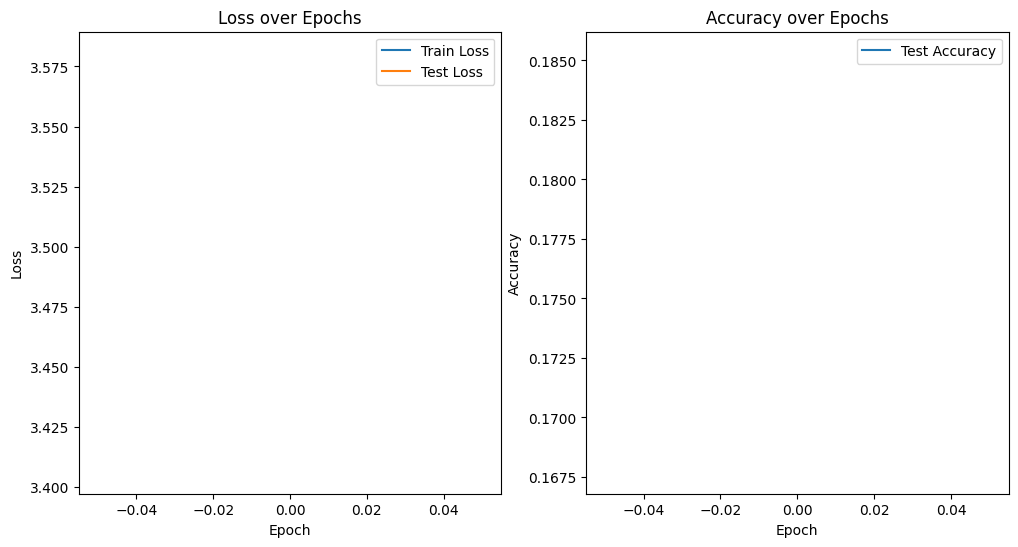

In [19]:
train_losses = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    # 훈련과정에서 손실을 기록
    train_loss = 0
    total_samples = 0
    net.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        total_samples += inputs.size(0)
    
    train_losses.append(train_loss / total_samples)

    # 평가 과정에서 손실과 정확도를 기록
    test_loss = 0
    correct = 0
    total = 0
    net.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    test_losses.append(test_loss / total)
    test_accuracies.append(correct / total)

# 손실과 정확도 그래프 그리기
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**Top-1 Accuracy**

In [20]:
def calculate_top1_accuracy(model, device, data_loader, criterion):
    model.eval()  # 모델을 평가 모드로 설정
    correct = 0
    total = 0
    
    with torch.no_grad():  # 그래디언트 계산 비활성화
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

            # # 각 샘플에 대한 예측 결과와 실제 레이블 출력
            # for i in range(data.size(0)):
            #     print(f"Sample {i + 1}: Predicted = {predicted[i].item()}, Actual = {target[i].item()}")

    top1_accuracy = 100 * correct / total
    print(f"Top-1 Accuracy: {top1_accuracy:.2f}%")

In [94]:
def calculate_top1_accuracy(model, device, data_loader, criterion):
    model.eval()  # 모델을 평가 모드로 설정
    correct = 0
    total = 0
    
    with torch.no_grad():  # 그래디언트 계산 비활성화
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

            # # 각 샘플에 대한 예측 결과와 실제 레이블 출력
            # for i in range(data.size(0)):
            #     print(f"Sample {i + 1}: Predicted = {predicted[i].item()}, Actual = {target[i].item()}")

    top1_accuracy = 100 * correct / total
    print(f"Top-1 Accuracy: {top1_accuracy:.2f}%")

In [101]:
# 모델 훈련 후 검증 데이터셋에 대한 Top-1 정확도 계산 및 출력
calculate_top1_accuracy(net, device, test_loader, criterion)

Top-1 Accuracy: 17.65%


**Top-5 Accuracy**

In [87]:
def calculate_and_print_top5_accuracy(model, device, data_loader, criterion):
    model.eval()  # 모델을 평가 모드로 설정
    correct = 0
    total = 0
    
    with torch.no_grad():  # 그래디언트 계산 비활성화
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            # Top-5 예측 결과 가져오기
            _, predicted_top5 = torch.topk(outputs, 5, dim=1)
            total += target.size(0)
            
            # 예측된 Top-5 내에 실제 레이블이 있는지 확인
            correct += (predicted_top5 == target.view(-1, 1)).sum().item()

    top5_accuracy = 100 * correct / total
    print(f"Top-5 Accuracy: {top5_accuracy:.2f}%")

In [103]:
calculate_and_print_top5_accuracy(net, device, test_loader, criterion)

Top-5 Accuracy: 45.57%


**SuperClass Accuracy**

In [53]:
fine_to_superclass = {
    # aquatic mammals
    4: 0, 30: 0, 55: 0, 72: 0, 95: 0,
    
    # fish
    1: 1, 32: 1, 67: 1, 73: 1, 91: 1,
    
    # flowers
    54: 2, 62: 2, 70: 2, 82: 2, 92: 2,
    
    # food containers
    9: 3, 10: 3, 16: 3, 28: 3, 61: 3,
    
    # fruit and vegetables
    0: 4, 51: 4, 53: 4, 57: 4, 83: 4,
    
    # household electrical devices
    22: 5, 39: 5, 40: 5, 86: 5, 87: 5,
    
    # household furniture
    5: 6, 20: 6, 25: 6, 84: 6, 94: 6,
    
    # insects
    6: 7, 7: 7, 14: 7, 18: 7, 24: 7,
    
    # large carnivores
    3: 8, 42: 8, 43: 8, 88: 8, 97: 8,
    
    # large man-made outdoor things
    12: 9, 17: 9, 37: 9, 68: 9, 76: 9,
    
    # large natural outdoor scenes
    23: 10, 33: 10, 49: 10, 60: 10, 71: 10,
    
    # large omnivores and herbivores
    15: 11, 19: 11, 21: 11, 31: 11, 38: 11,
    
    # medium-sized mammals
    34: 12, 63: 12, 64: 12, 66: 12, 75: 12,
    
    # non-insect invertebrates
    26: 13, 45: 13, 77: 13, 79: 13, 99: 13,
    
    # people
    2: 14, 11: 14, 35: 14, 46: 14, 98: 14,
    
    # reptiles
    27: 15, 29: 15, 44: 15, 78: 15, 93: 15,
    
    # small mammals
    36: 16, 50: 16, 65: 16, 74: 16, 80: 16,
    
    # trees
    47: 17, 52: 17, 56: 17, 59: 17, 96: 17,
    
    # vehicles 1
    8: 18, 13: 18, 48: 18, 58: 18, 90: 18,
    
    # vehicles 2
    41: 19, 69: 19, 81: 19, 85: 19, 89: 19
}


In [56]:
def superclass_accuracy(model, device, data_loader, criterion, k=1, super=False):
    model.eval()  # 모델을 평가 모드로 설정
    correct = 0
    total = 0
    
    with torch.no_grad():  # 그래디언트 계산 비활성화
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)

            _, predicted = torch.topk(outputs, k, dim=1)

            if super:  # 슈퍼클래스 기준으로 계산
                # 세부 클래스를 슈퍼클래스로 변환
                target_super = torch.tensor([fine_to_superclass[t.item()] for t in target], device=device)
                predicted_super = torch.tensor([fine_to_superclass[p.item()] for p in predicted.view(-1)], device=device).view_as(predicted)                
                correct += (predicted_super == target_super.view(-1, 1)).sum().item()
            else:  # 세부 클래스 기준으로 계산
                correct += (predicted == target.view(-1, 1)).sum().item()
            
            total += target.size(0)

    accuracy = 100 * correct / total
    
    if not super:
        print(f"Top-{k} Accuracy: {accuracy:.2f}%")
    else:
        print(f"Super-{k} Accuracy: {accuracy:.2f}%")

In [105]:
superclass_accuracy(net, device, test_loader, criterion, 1, True)

Super-1 Accuracy: 24.15%


# Data Analysis - 현욱

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir=./runs/resnet_18/tensorboard --port=8202 --host=0.0.0.0

### **Classes**

In [62]:
classes = train_val_data.classes
coarse_classes = [
    'aquatic mammals', 'fish', 'flowers', 'food containers', 'fruit and vegetables', 'household electrical devices', 
    'household furniture', 'insects', 'large carnivores', 'large man-made outdoor things', 
    'large natural outdoor scenes', 'large omnivores and herbivores', 'medium-sized mammals', 
    'non-insect invertebrates', 'people', 'reptiles', 'small mammals', 'trees', 'vehicles 1', 'vehicles 2'
]

In [63]:
print(len(classes), len(coarse_classes))

100 20


### **Confusion Matrix**

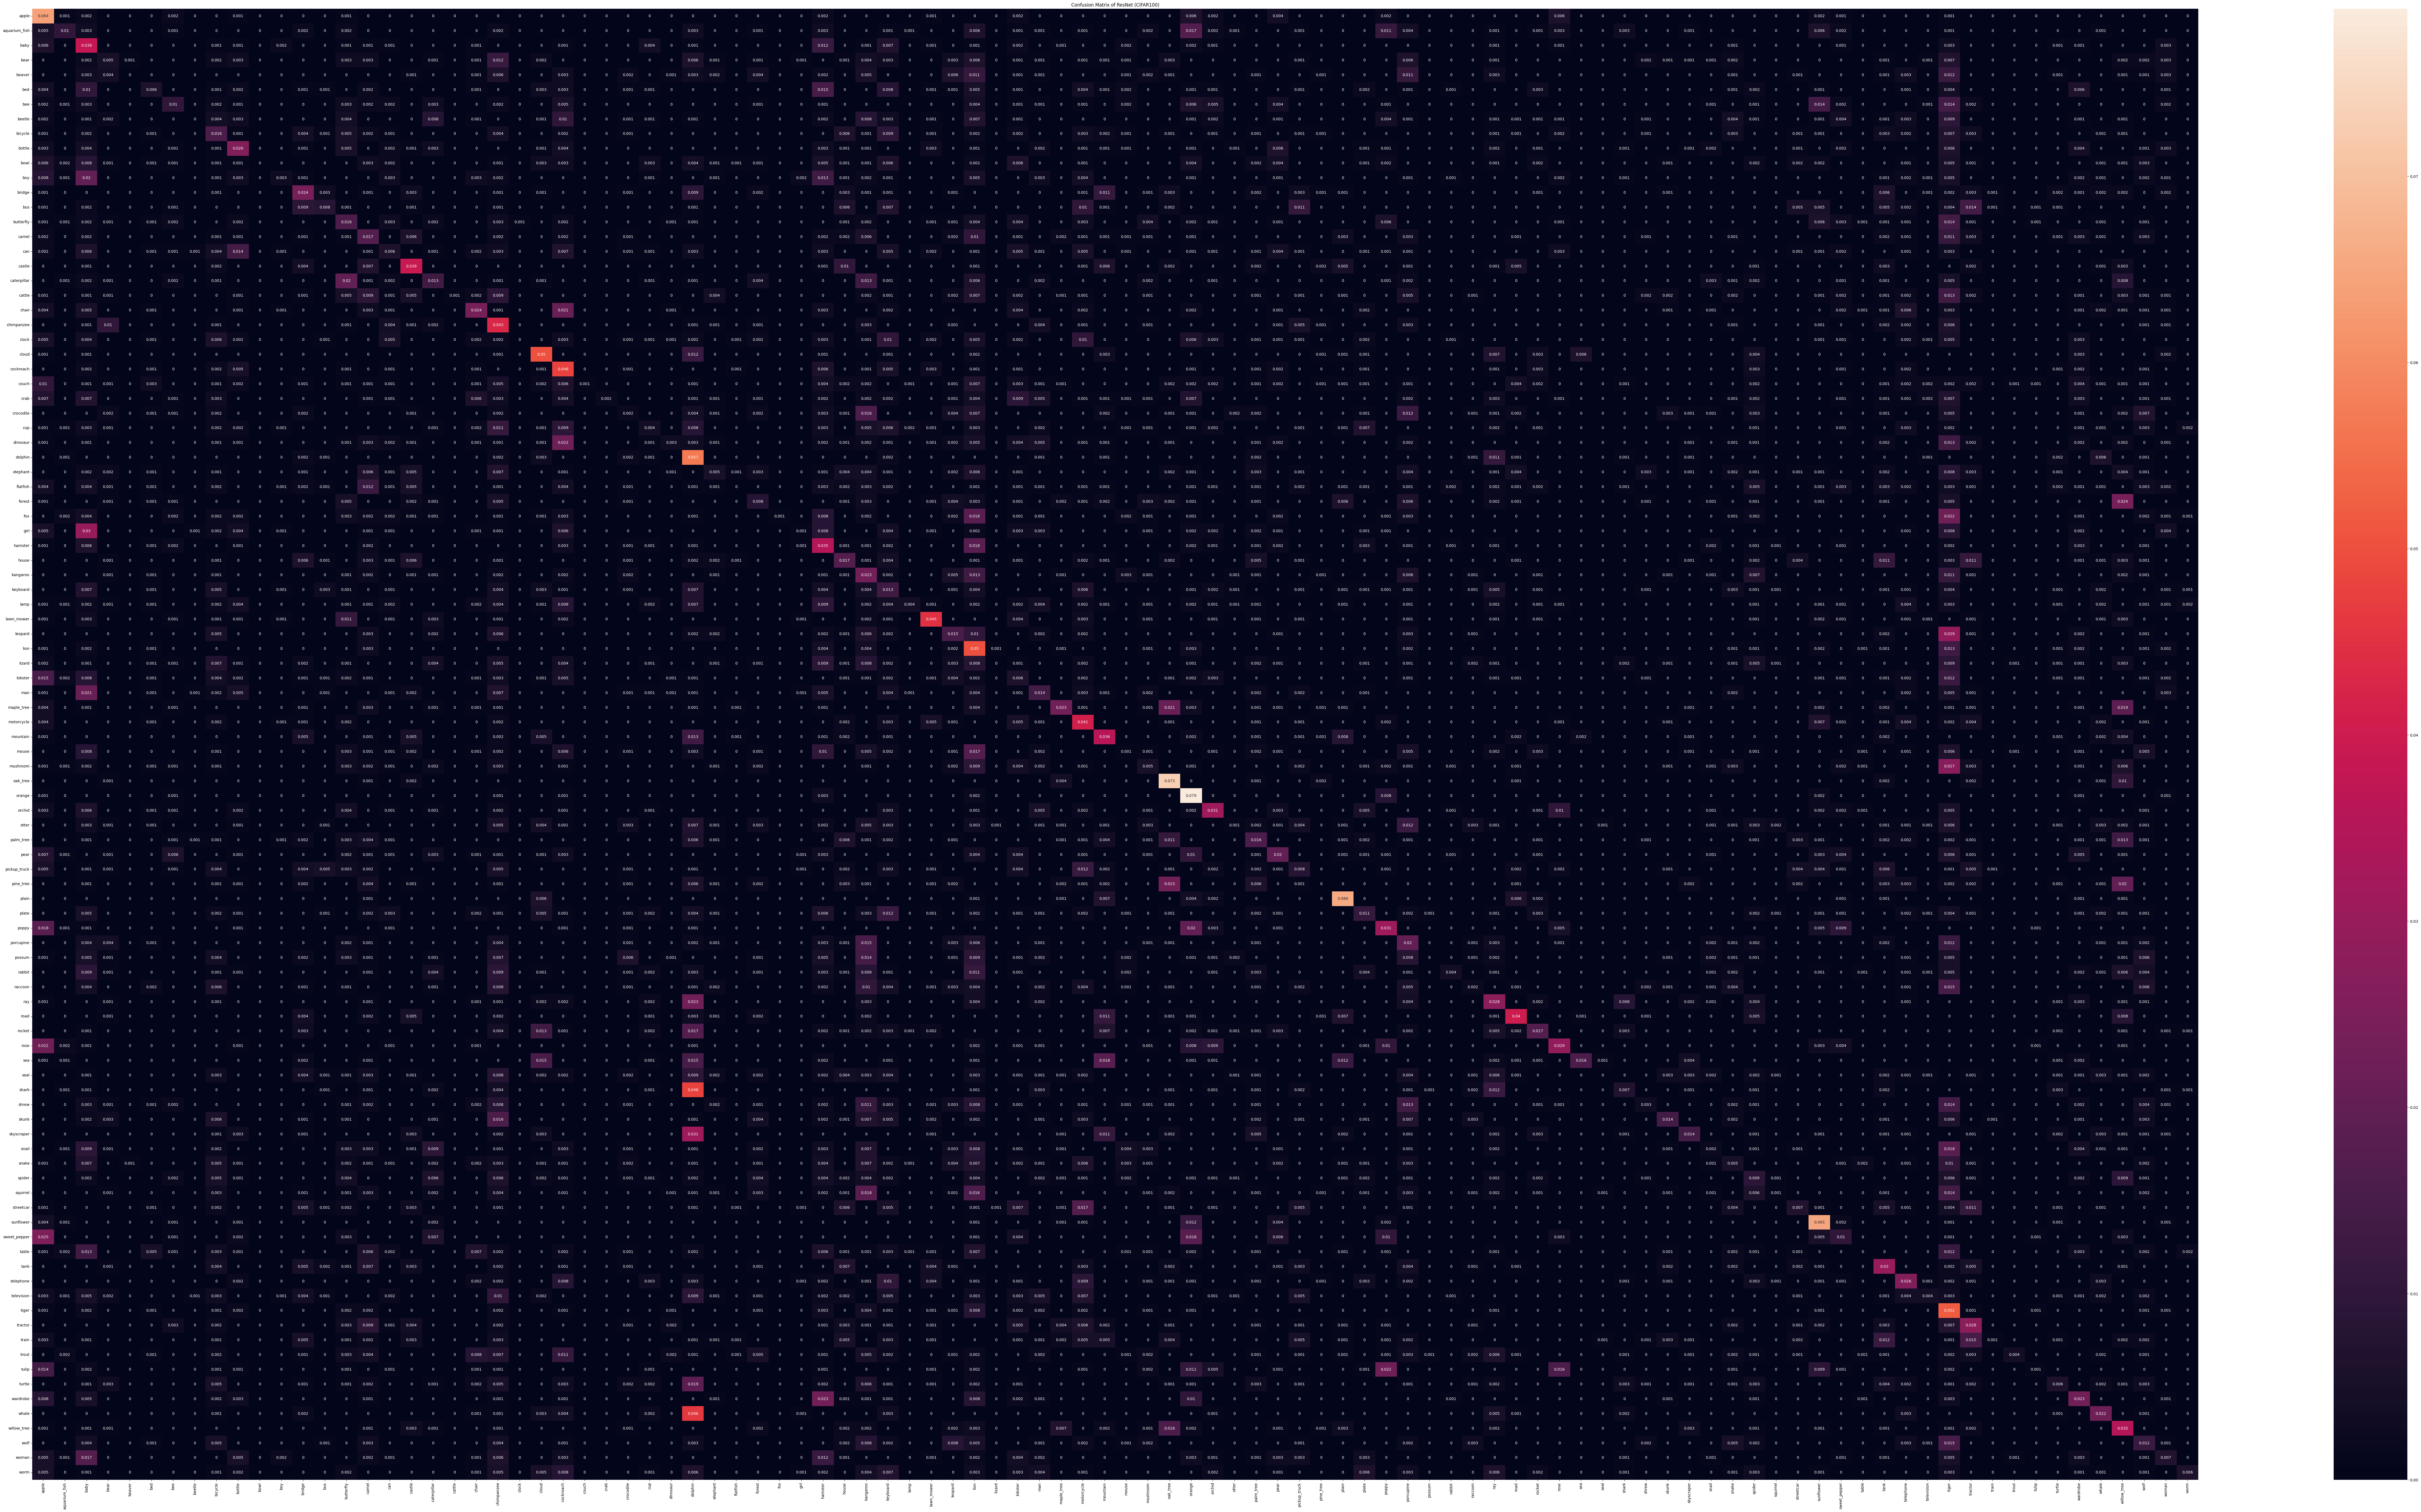

In [64]:
y_pred = []
y_true = []

# iterate over test data
for x, y in torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size):
    
    #print('iter val', i)
    x = x.to(device)
    y = y.to(device)
    z = net(x)
    _, yhat = torch.max(z, 1)
    pred = yhat.data.cpu().numpy()
    y_pred.extend(pred) # Save Prediction

    labels = y.data.cpu().numpy()
    y_true.extend(labels) # Save Truth

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (128,70))
sns.heatmap(df_cm, annot=True)
plt.title('Confusion Matrix of ResNet (CIFAR100)')
plt.savefig('./runs/resnet_18/Confusion_matrix_ResNet_Cifar100.jpg')

In [68]:
print(f" Classification Report of ResNet(CIFAR100)  \n { classification_report(y_true, y_pred)}")

 Classification Report of ResNet(CIFAR100)  
               precision    recall  f1-score   support

           0       0.25      0.07      0.11       700
           1       0.35      0.18      0.23       500
           2       0.23      0.21      0.22       600
           3       0.18      0.26      0.21       400
           4       0.20      0.30      0.24       500
           5       0.29      0.41      0.34       500
           6       0.21      0.05      0.09       500
           7       0.18      0.05      0.08       200
           8       0.16      0.34      0.21       400
           9       0.22      0.36      0.28       600
          10       0.20      0.27      0.23       400
          11       0.33      0.41      0.36       400
          12       0.24      0.20      0.22       400
          13       0.14      0.04      0.06       400
          14       0.12      0.18      0.14       400
          15       0.25      0.14      0.18       600
          16       0.21      0.20  

In [ ]:
# Save Classification Report as txt file 
with open("./runs/resnet_18/cr_ResNet18.txt", "w") as text_file:
    print(classification_report(y_true, y_pred, digits=4), file=text_file)

In [ ]:
# Load Classification Report txt file 
with open("./runs/resnet_18/cr_ResNet18.txt", "r") as f:
  cr = f.read()
print(cr)

### **Confusion Matrix - Coarse**

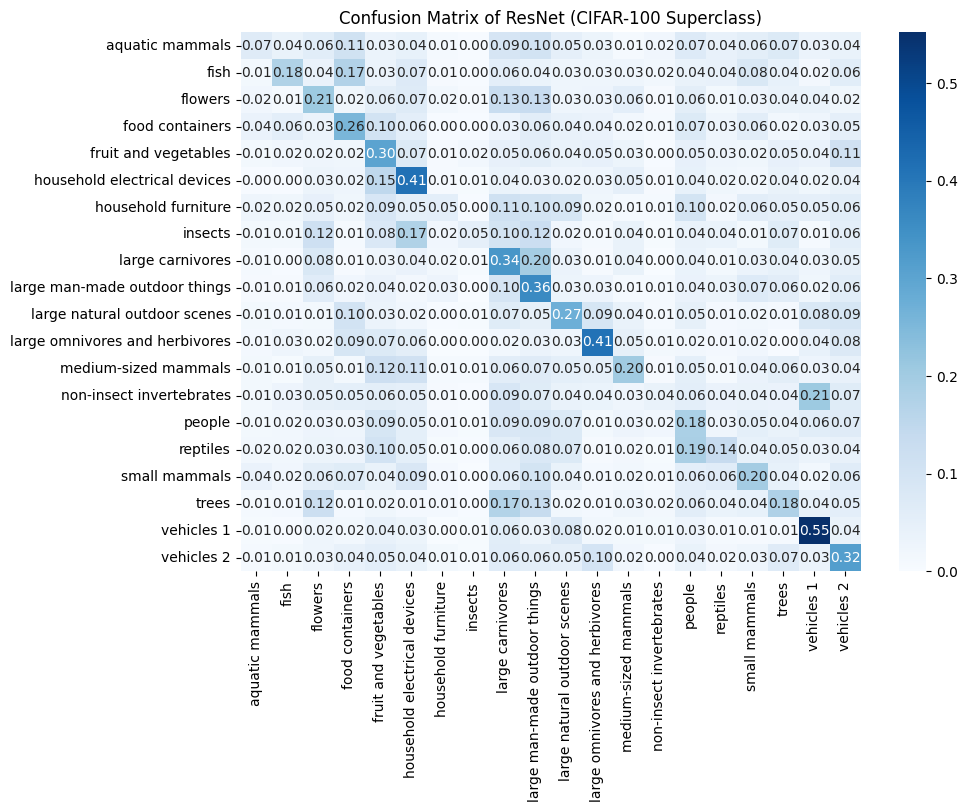

In [80]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

y_pred = []
y_true = []

# iterate over test data
for x, y in torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size):
    x = x.to(device)
    y = y.to(device)
    z = net(x)
    _, yhat = torch.max(z, 1)
    
    # Save Prediction and convert to superclasses
    pred = yhat.data.cpu().numpy()
    super_pred = [fine_to_superclass[p] for p in pred]
    y_pred.extend(super_pred)
    
    # Save Truth and convert to superclasses
    labels = y.data.cpu().numpy()
    super_labels = [fine_to_superclass[l] for l in labels]
    y_true.extend(super_labels)

# Build confusion matrix for superclasses
cf_matrix = confusion_matrix(y_true, y_pred, normalize='true')

# Normalize confusion matrix
df_cm = pd.DataFrame(cf_matrix, index=coarse_classes,
                     columns=coarse_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap='Blues')
plt.title('Confusion Matrix of ResNet (CIFAR-100 Superclass)')
plt.savefig('./runs/resnet_18/Confusion_matrix_ResNet_Cifar100_superclass.jpg')
plt.show()


### **Classification Report**

In [67]:
print(f"Super Classification Report of ResNet(CIFAR100)  \n { classification_report(y_true, y_pred)}")

 Classification Report of ResNet(CIFAR100)  
               precision    recall  f1-score   support

           0       0.25      0.07      0.11       700
           1       0.35      0.18      0.23       500
           2       0.23      0.21      0.22       600
           3       0.18      0.26      0.21       400
           4       0.20      0.30      0.24       500
           5       0.29      0.41      0.34       500
           6       0.21      0.05      0.09       500
           7       0.18      0.05      0.08       200
           8       0.16      0.34      0.21       400
           9       0.22      0.36      0.28       600
          10       0.20      0.27      0.23       400
          11       0.33      0.41      0.36       400
          12       0.24      0.20      0.22       400
          13       0.14      0.04      0.06       400
          14       0.12      0.18      0.14       400
          15       0.25      0.14      0.18       600
          16       0.21      0.20  

In [ ]:
# Save Classification Report as txt file 
with open("./runs/resnet_18/scr_ResNet18.txt", "w") as text_file:
    print(classification_report(y_true, y_pred, digits=4), file=text_file)

In [ ]:
# Load Classification Report txt file 
with open("./runs/resnet_18/scr_ResNet18.txt", "r") as f:
  cr = f.read()
print(cr)

In [74]:
temp_dic = dict()
for i, c in enumerate(classes):
    temp_dic[i] = c

print(temp_dic)

temp2_dic = dict()
for i in range(100):
    temp2_dic[temp_dic[i]] = fine_to_superclass[i]

print(temp2_dic)

{0: 'apple', 1: 'aquarium_fish', 2: 'baby', 3: 'bear', 4: 'beaver', 5: 'bed', 6: 'bee', 7: 'beetle', 8: 'bicycle', 9: 'bottle', 10: 'bowl', 11: 'boy', 12: 'bridge', 13: 'bus', 14: 'butterfly', 15: 'camel', 16: 'can', 17: 'castle', 18: 'caterpillar', 19: 'cattle', 20: 'chair', 21: 'chimpanzee', 22: 'clock', 23: 'cloud', 24: 'cockroach', 25: 'couch', 26: 'crab', 27: 'crocodile', 28: 'cup', 29: 'dinosaur', 30: 'dolphin', 31: 'elephant', 32: 'flatfish', 33: 'forest', 34: 'fox', 35: 'girl', 36: 'hamster', 37: 'house', 38: 'kangaroo', 39: 'keyboard', 40: 'lamp', 41: 'lawn_mower', 42: 'leopard', 43: 'lion', 44: 'lizard', 45: 'lobster', 46: 'man', 47: 'maple_tree', 48: 'motorcycle', 49: 'mountain', 50: 'mouse', 51: 'mushroom', 52: 'oak_tree', 53: 'orange', 54: 'orchid', 55: 'otter', 56: 'palm_tree', 57: 'pear', 58: 'pickup_truck', 59: 'pine_tree', 60: 'plain', 61: 'plate', 62: 'poppy', 63: 'porcupine', 64: 'possum', 65: 'rabbit', 66: 'raccoon', 67: 'ray', 68: 'road', 69: 'rocket', 70: 'rose', 